In [1]:
import itertools
import os
import pickle
import random

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score

from constants import experiment_set, protein_list, protein_names
from utils import get_class, get_model, load_data_sources, reset_seeds


# Set random seeds for reproducibility.

reset_seeds()

# When running on a GPU, some operations have non-deterministic outputs.
# Force the code to run on a single core of the CPU.
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3

In [2]:
table_data = {}
training_set_number = 0

# We have to generate combinations with differnet lengths, thus we generate length intigers and create sets with all combinations at given length.
for length in range(1, 5):
    for set in itertools.combinations(experiment_set, length):

        average_score = np.zeros(len(protein_list))
        score_list = []

        for protein in protein_list:

            data_sources, X = load_data_sources(
                protein, "train", training_set_number, *set
            )
            y = get_class(protein, "train", training_set_number)
            size = X.shape[2]
            score = []
            
            reset_seeds()
            model = get_model(size)

            model.compile(
                loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
            )

        earlystopper = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
        metrics = model.fit(
            X,
            y,
            validation_split=0.2,
            epochs=12,
            batch_size=200,
            verbose=1,
            callbacks=[earlystopper],
        )

            # Run predictions on test dataset.
            data_sources, X_test = load_data_sources(protein, "test", 0, *set)
            y_test = get_class(protein, "test", training_set_number)

            y_scores = model.predict(X_test)
            y_scores = y_scores[:, 0:1]
            y_test = y_test[:, 0:1]
            score = roc_auc_score(y_test, y_scores)
            score_list.append(score)

        print(protein)
        table_data[data_sources] = score_list

        with open("results/auc_combinations_results.pickle", "wb") as f:
            pickle.dump(table_data, f, protocol=pickle.HIGHEST_PROTOCOL)


1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19


In [3]:
def highlight_max(s):
    is_max = s == max(s)
    return ["background-color: yellow" if v else "" for v in is_max]


with open("results/auc_combinations_results.pickle", "rb") as f:
    loaded_table_data = pickle.load(f)

for dict_value in loaded_table_data:
    loaded_table_data[dict_value] = np.round(np.array(loaded_table_data[dict_value]), 3)

loaded_table = pd.DataFrame(
    loaded_table_data, index=[i + 1 for i in range(len(protein_list))]
)
loaded_table = loaded_table.T
loaded_table = loaded_table.reindex(sorted(loaded_table.columns), axis=1)

loaded_table.style.apply(highlight_max)


,1
SEQ,0.725000
RNA,0.643000
RG,0.854000
CLIP,0.860000
"SEQ,RNA",0.760000
"SEQ,RG",0.885000
"SEQ,CLIP",0.897000
"RNA,RG",0.874000
"RNA,CLIP",0.893000
"RG,CLIP",0.927000


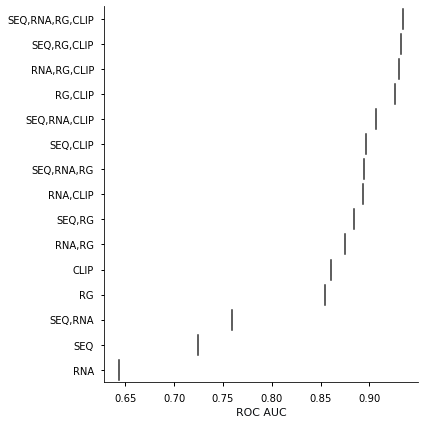

In [4]:
import pandas as pd
import seaborn as sns
from collections import OrderedDict
import matplotlib.style as style

style.use("seaborn-notebook")

if not os.path.exists("results/figures"):
    os.makedirs("results/figures")

with open("results/auc_combinations_results.pickle", "rb") as f:
    table_data = pickle.load(f)

loaded_table_data = {}
for source in table_data.keys():
    loaded_table_data[source] = np.average(table_data[source])

sorted_data = OrderedDict(sorted(loaded_table_data.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel("ROC AUC", color="#0A0C0F")
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
df = pd.DataFrame.from_dict(table_data)
box = sns.boxplot(
    data=df,
    orient="h",
    order=list(sorted_data.keys())[::-1],
    palette=sns.color_palette("Blues", n_colors=1),
    ax=ax,
    saturation=1,
)
plt.tight_layout()
plt.savefig("results/figures/box_averages_data_sources.pdf")

/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
[nan, nan, nan, nan]
[nan, nan, nan, nan]
[nan, nan, nan, nan]
[nan, nan, nan, nan]


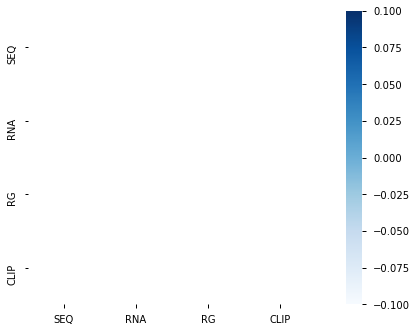

In [5]:
from scipy import stats
from scipy.stats.stats import pearsonr

with open("results/auc_combinations_results.pickle", "rb") as f:
    loaded_table_data = pickle.load(f)

    index = ["SEQ", "RNA", "RG", "CLIP"]
    df = pd.DataFrame(index=index)

    for source in index:
        correlation = [
            (pearsonr(loaded_table_data[source], loaded_table_data[s]))[0]
            for s in index
        ]
        print(correlation)
        df1 = pd.DataFrame(correlation, index=index, columns=[source])
        df = df.join(df1)

    grid_kws = {"width_ratios": (0.9, 0.05)}
    fig, (ax, cbar_ax) = plt.subplots(
        nrows=1, ncols=2, figsize=(6, 5.4), gridspec_kw=grid_kws
    )
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(
        df,
        cmap=sns.color_palette("Blues", as_cmap=True),
        annot=True,
        mask=mask,
        ax=ax,
        cbar_ax=cbar_ax,
    )
    plt.savefig("results/figures/data_sources_correlation_mask.pdf", pad_inches=0)


In [6]:
from scipy.cluster.hierarchy import linkage, dendrogram

individual_sources = np.zeros((4, 31))
with open("results/auc_combinations_results.pickle", "rb") as f:
    loaded_table_data = pickle.load(f)
individual_sources = {k: loaded_table_data[k] for k in ["SEQ", "RNA", "RG", "CLIP"]}

data = pd.DataFrame(individual_sources).to_numpy()
row_linkage = linkage(data, method="ward", metric="euclidean", optimal_ordering=True)
col_linkage = linkage(data.T, method="ward", metric="euclidean", optimal_ordering=True)

sns.set(font_scale=1.1)

#     print(loaded_table_data)
g = sns.clustermap(
    data,
    method="ward",
    cmap=sns.color_palette("Blues"),
    yticklabels=protein_names,
    xticklabels=["SEQ", "RNA", "RG", "CLIP"],
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    figsize=(6, 9),
    dendrogram_ratio=(0.3, 0.05),
    cbar_pos=(0, 0.8, 0.03, 0.2),
)
plt.savefig("results/figures/protein_cluster_data_sources.pdf", pad_inches=1)

ValueError: The number of observations cannot be determined on an empty distance matrix.